# Imports and Functions

In [1]:
from sunlab.environment.base.cuda import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.suntorch import *

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import torch

# Setup

## Model

In [4]:
dataset_file_name = FILES['TRAINING_DATASET']
model_directory = "../../test_models/autoencoder_v/"
test_dataset_files = [FILES['SPHEROID']['3mgml'],FILES['SPHEROID']['4mgml'],FILES['SPHEROID']['6mgml']]
normalization_scaler = MaxAbsScaler
distribution = GaussianDistribution
magnification = 10
latent_size = 2
batch_size = 1024
shuffle=True
val_split=0.1
autoencoder_depth = 3
use_leaky_relu = False
equal_split = True

In [5]:
dataScaler = MaxAbsScaler(DIR_ROOT + "models/current_model/").load()
trainShapeDataset = ShapeDataset(dataset_file_name, scaler=dataScaler, batch_size=batch_size, shuffle=True, val_split=val_split,equal_split=equal_split)

/home/physics/cunnichr/.micromamba/envs/pt_116/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MaxAbsScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
test_datasets = [import_dataset(dataset, magnification, scaler=dataScaler) for dataset in test_dataset_files]
test_dataset = np.vstack([test_dataset.dataset for test_dataset in test_datasets])

In [7]:
DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
full_dataset = torch.tensor(trainShapeDataset.dataset.astype(np.single)).to(DEV)

In [9]:
classification_dataset_dict = np.load(DIR_ROOT + "extra_data/ClassificationTestingDataset.npy", allow_pickle=True).item()
classification_dataset = torch.tensor(classification_dataset_dict['normalized_dataset'].astype(np.single)).to(DEV)

In [10]:
training_dataset = torch.tensor(dataScaler(trainShapeDataset.training_data).astype(np.single)).to(DEV)
validation_dataset = torch.tensor(dataScaler(trainShapeDataset.validation_data).astype(np.single)).to(DEV)
test_dataset = torch.tensor(test_dataset.astype(np.single)).to(DEV)

In [11]:
training_data = []
training_classification_data = []

In [21]:
import timeit
for n_tests in range(12):
    vae = VariationalAutoencoder(13, 2, 16)
    vae.init_losses().init_optimizers().to(DEV)
    pbar = tqdm(range(1600))
    start_time = timeit.default_timer()
    for _ in pbar:
        for step in range(training_dataset.shape[0]//batch_size):
            data = training_dataset[(step*batch_size):((step+1)*batch_size), :]
            vae.train_step(data)
            vae.eval()
            mae_t = torch.mean(torch.abs(training_dataset - vae(training_dataset)[0])).item()
            mae_v = torch.mean(torch.abs(validation_dataset - vae(validation_dataset)[0])).item()
            vae.train()
            pbar.set_postfix({
                "tMAE": mae_t,
                "vMAE": mae_v,
            })
    elapsed_train = timeit.default_timer() - start_time
    start_time = timeit.default_timer()
    run_this = vae(full_dataset)
    elapsed_inference = timeit.default_timer() - start_time

    ae_t = torch.abs(training_dataset - vae(training_dataset)[0])
    ae_v = torch.abs(validation_dataset - vae(validation_dataset)[0])
    ae_T = torch.abs(test_dataset - vae(test_dataset)[0])
    mae_t = torch.mean(ae_t).item()
    mae_v = torch.mean(ae_v).item()
    mae_T = torch.mean(ae_T).item()
    rmse_t = torch.mean(torch.pow((torch.mean(torch.pow(ae_t, 2.), axis=-1)),(1./2.))).item()
    rmse_v = torch.mean(torch.pow((torch.mean(torch.pow(ae_v, 2.), axis=-1)),(1./2.))).item()
    rmse_T = torch.mean(torch.pow((torch.mean(torch.pow(ae_T, 2.), axis=-1)),(1./2.))).item()
    rmpe_t = torch.mean(torch.pow((torch.mean(torch.pow(ae_t, 13.), axis=-1)),(1./13.))).item()
    rmpe_v = torch.mean(torch.pow((torch.mean(torch.pow(ae_v, 13.), axis=-1)),(1./13.))).item()
    rmpe_T = torch.mean(torch.pow((torch.mean(torch.pow(ae_T, 13.), axis=-1)),(1./13.))).item()
    training_data.append((1, 2, 1600, elapsed_train, elapsed_inference,
                 mae_t, mae_v, mae_T,
                 rmse_t, rmse_v, rmse_T,
                 rmpe_t, rmpe_v, rmpe_T))
    training_classification_data.append(
        dataScaler.scaler.inverse_transform((vae(classification_dataset)[0].detach().cpu().numpy()))
    )

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

In [22]:
assert False, "Don't overwrite"
np.save(f"../../classification_results_vae.npy", dict(results=np.array(training_classification_data)))

In [ ]:
assert False, "Don't overwrite"
np.save(f"../../results_three_vae.npy", dict(results=training_data))

In [ ]:
training_data

In [11]:
vae = VariationalAutoencoder(13, 2, 16)
vae.init_losses().init_optimizers().to(DEV)

In [12]:
pbar = tqdm(range(1600))
for _ in pbar:
    for step in range(training_dataset.shape[0]//batch_size):
        data = training_dataset[(step*batch_size):((step+1)*batch_size), :]
        vae.train_step(data)
        vae.eval()
        mae_t = torch.mean(torch.abs(validation_dataset - vae(validation_dataset)[0])).item()
        mae_v = torch.mean(torch.abs(validation_dataset - vae(validation_dataset)[0])).item()
        vae.train()
        pbar.set_postfix({
            "tMAE": mae_t,
            "vMAE": mae_v,
        })

  0%|          | 0/1600 [00:00<?, ?it/s]

In [13]:
latent = vae.encoder(full_dataset)[0].detach().cpu().numpy()

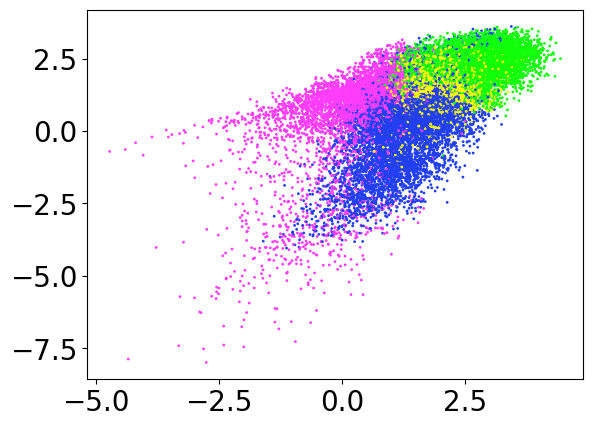

In [14]:
plt.scatter(latent[:,0], latent[:,1], c=trainShapeDataset.labels, cmap=Pmap, s=1)

# Depth Checking

In [15]:
from scipy.spatial import KDTree

In [16]:
latent_vectors = latent.copy()
latent_vectors.shape

(19479, 2)

In [17]:
tree = KDTree(latent_vectors)

In [18]:
dataset = trainShapeDataset

In [19]:
R = np.inf
# R = 0.05 # np.inf
N = 13*2 # latent_vectors.shape[0]
# N = 4 # latent_vectors.shape[0]

In [20]:
res = [tree.query(latent_vectors[dataset.labels==phenotype], N, distance_upper_bound=R) for phenotype in range(4)]

In [21]:
from tqdm.auto import tqdm

In [22]:
phenotype_neighbors = dict()
for phenotype in tqdm(range(4)):
    cells = np.argwhere(dataset.labels == phenotype)
    dists, indxs = res[phenotype]

    neighbors = {i: 0 for i in range(4)}
    for row in range(dists.shape[0]):
    #     cell = cells[row]
        classes = dataset.labels[indxs[row,~np.isinf(dists[row,...]).squeeze()]].astype(np.uint8)
        phenotypes, counts = np.unique(classes, return_counts=True)
        for i in range(phenotypes.shape[0]):
            neighbors[int(phenotypes[i])] += counts[i]

    phenotype_neighbors[phenotype] = neighbors
phenotype_neighbors

  0%|          | 0/4 [00:00<?, ?it/s]

{0: {0: 29001, 1: 3629, 2: 22335, 3: 21163},
 1: {0: 3696, 1: 86089, 2: 2730, 3: 19753},
 2: {0: 22442, 1: 2595, 2: 113697, 3: 9856},
 3: {0: 21263, 1: 19322, 2: 9979, 3: 118904}}

In [23]:
phenotype_names = ['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']

In [24]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    r = counts[phenotype]/sum(counts)
    print(counts)
    print(r*100)

ActinEdge
[29001, 3629, 22335, 21163]
38.09505044136191
Filopodia
[3696, 86089, 2730, 19753]
76.68169024120853
Bleb
[22442, 2595, 113697, 9856]
76.51726226529377
Lamellipodia
[21263, 19322, 9979, 118904]
70.16309863809097


In [25]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    fixed_normalization = (2*counts[phenotype]-sum(counts))/N
    phenotype_relative_normalization = (2*counts[phenotype]-sum(counts))/np.sum(dataset.labels==phenotype)
    print(counts)
    print(fixed_normalization)
    print(phenotype_relative_normalization)

ActinEdge
[29001, 3629, 22335, 21163]
-697.1538461538462
-6.190573770491803
Filopodia
[3696, 86089, 2730, 19753]
2304.230769230769
13.87447892542844
Bleb
[22442, 2595, 113697, 9856]
3030.923076923077
13.788976377952755
Lamellipodia
[21263, 19322, 9979, 118904]
2628.4615384615386
10.484811291807302


In [29]:
SAVE_EXTRAS=False
g_Base = lambda *args: DIR_ROOT + "Figures/VAE/Invasion/"

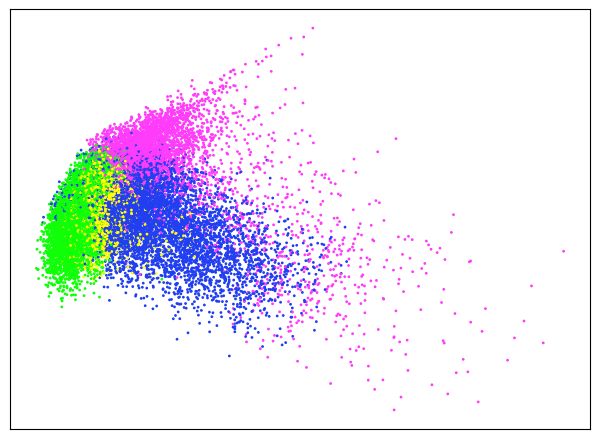

In [28]:
plt.scatter2d(latent_vectors, c=dataset.labels, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "VAE")

# END